---
### **<p style="text-align: center; text-decoration: underline;">Bayesian Machine Learning Project</p>**
# **<p style="text-align: center;">Bayesian Learning via Stochastic Gradient Langevin Dynamics</p>**
---

> Realized by: *Zakaria Boulkhir* & *Omar Iken*.

> Master 2, Data Science, Lille University.

---

### ■ __Overview__
This [project](https://github.com/rbardenet/bml-course/blob/m2-lille/projects/papers.pdf) is part of the lecture on *Bayesian Machine Learning* tought by [Rémi BARDENET](https://rbardenet.github.io/). The idea is to pick a paper from a list of given papers, and read it with a critical mind. For instance, we will:
- (1) explain the contents of the paper
- (2) emphasize the strong and weak points of the paper
- (3) apply it to real data of our choice when applicable.

So this notebook concerns the implementation part of the project.

### ■ __Article__
M. Welling and Y. W. Teh. Bayesian learning via stochastic gradient Langevin
dynamics. In Proceedings of the 28th international conference on machine learning
(ICML-11), pages 681–688, 2011.

The main article is available [here](http://people.ee.duke.edu/~lcarin/398_icmlpaper.pdf).

### ■ __Motivation__
- Emergence of large-scale data sets.
- Promising results from SGD.
- Bayesian MCMC methods require the entire dataset, which is expensive in terms of time and memory.

### ■ __SGLD__
- Change the gradient of the Langevin dynamics to mini-batch estimation.
- Inject noise into the parameter updates such that the parameter trajectory converges to the full posterior distribution.
- Noise variance is balanced with gradient step sizes.
- The step size must go to zero.

The proposed method utilizes updates similar to stochastic gradient descent, but injects the right amount of noise, so that the resulting sample set approaches the posterior distribution rather than a point estimate. The resulting algorithm starts oﬀ being similar to stochastic optimization, then automatically transitions to an algorithm that simulates samples of the posterior using Langevin dynamics.

### ■ **<a name="content">Contents</a>**

- [1. Dataset](#dataset)

- [2. Implementation](#imp)

    - [2.1. Preliminaries]()
    
    - [2.2. Stochastic Gradient Langevin Dynamics (SGLD)]()
    
    - [2.3. Posterior Sampling]()
    
    
- [3. Experiments](#eval)

    - [3.1. Mixture of Gaussians]()
    
    - [3.2. Logistic Regression]()
    
    - [3.3. Independent Components Analysis]()

### ■ **Libraries**
Let's start by uploading all the libraries needed for this project.

In [1]:
## numpy to handle arrays & matices
import numpy as np

## matplotlib & Seaborn to plot figures
import matplotlib.pyplot as plt
import seaborn as sns

## pandas to handle dataframes
import pandas as pd
from scipy import stats
from tqdm import tqdm

## sklearn dependencies
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report

In [2]:
#-----------< Setting >------------#
## set plots text font size & style
sns.set(font_scale=1.2, style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## dependecies versions
print(f'numpy version: {np.__version__}')

numpy version: 1.20.1


### ■ **<a name="dataset">1. Dataset</a>** [(&#8593;)](#content)
In this first section, we will load the dataset that we will use during this project. Then we will do some preprocessing and exploration.

#### **1.1. Artificial Data**
During this project, we will be working with both artificial and real data. The artificial data is generated as data-cases iid in six channels. Three channels had high kurtosis distributions while three others where normally distributed. The total number of generated samples is 1000.

In [3]:
def generate_art_data(n_samples):
    """generate artificial data"""
    
    normal_samples = np.random.normal(size=(n_samples, n_samples, 3))
    
    kurtosis_samples = stats.kurtosis(np.random.normal(size=(n_samples, n_samples, n_samples, 3)), fisher=True)

    data = np.concatenate((normal_samples, kurtosis_samples), axis=-1)
    
    return data

In [4]:
data = generate_art_data(100)

data.shape

(100, 100, 6)

#### **1.2. MEG Data**

### ■ **<a name="imp">2. Implementation</a>** [(&#8593;)](#content)
This second section concers implementing SGDL. The main goal is to do bayesian learning from large scale datasets. The main idea is to combine
two type of algorithms:
- *Stochastic Gradient Descent* algorithm (aka. Robbins-Monro) [\ref{SGD}]: which stochastically optimize a likelihood.
- *Langevin dynamics* [\ref{LD}]: which injects noise into the parameter updates in such a way that the trajectory of the parameters will converge to the full posterior distribution rather than just the maximum a posteriori mode.

The resulting algorithm starts off being similar to stochastic optimization, then automatically transitions to one that simulates samples from the posterior using Langevin dynamics.

$$
\tag{1}
\label{SGD}
\Delta\theta_t = \frac{\epsilon_t}{2}\left(\nabla\log p(\theta_t) + \frac{N}{n}\sum_{i=1}^{n}\nabla\log p(x_{ti}|\theta_t)\right)
$$

$$
\tag{2}
\label{LD}
\Delta\theta_t = \frac{\epsilon}{2}\left(\nabla\log p(\theta_t) + \sum_{i=1}^{N}\nabla\log p(x_{i}|\theta_t)\right) + \eta_t, \qquad \eta_t\sim\mathcal{N}(0, \epsilon)
$$

In order to this method to work, i.e. two ensure that the method will converge to a local maximum, two main conditions are required, and they concern the step size:
1. $\sum_{t=1}^{\infty}\epsilon_t = \infty$: to ensure that the parameters will reah the high probability regions whatever the starting point.
2. $\sum_{t=1}^{\infty}\epsilon_t^2 < \infty$: to ensure that the parameters will converge to the mode and not just bouncing around it.

#### **2.1. Preliminaries**

In [5]:
def lg_grad(w, X, y, r):
    """logistic regression"""
    
    return -np.dot(X.T, y - prob(w, X)) + r * w

#### **2.2. Stochastic Gradient Langevin Dynamics (SGLD)**

Based on the similarities between the two algorithms (1) and (2), the idea is to combine the two approaches. This will lead to an efficient use of large data sets while allowing to take into account the uncertainty of the parameters in a Bayesian way.

The process is as follows: 
1. use stochastic gradients descent
2. add an amount of Gaussian noise balanced against the parameter uncertainty.
3. allow the step sizes to go to zero. :

Thus the proposed update is given by:

$$
\tag{3}
\label{SGDL}
\Delta\theta_t = \frac{\epsilon_t}{2}\left(\nabla\log p(\theta_t) + \frac{N}{n}\sum_{i=1}^{n}\nabla\log p(x_{ti}|\theta_t)\right) + \eta_t, \qquad \eta_t\sim\mathcal{N}(0, \epsilon)
$$

In [6]:
def SGLD(X, log_prior, log_likelihood, batch_size, epsilon, n_iter, y=None, random_state=None):
    
    """Stochastic Gradient Langevin Dynamics
    
    Parameters
    ----------
    X : array like of shape (N, d),
        The training samples.
    
    log_prior: callable,
        The log prior of the model.
        
    log_likelihood: callable,
        The log likelihhod of the model.
        
    batch_size: int,
        The size of the mini-batch.
        
    epsilon: float or callable,
        The step size.
        
    n_iter: int,
        Number of iterations to perform.
        
    theta_zero: array like of shape (d, 1)
        Instantiating of parameters.
        
    random_state: int, DEFAULT=None,
        Random seed for reproducibility.
    
    Returns
    -------
        Thetas: array like of shape (n_iter, d),
            The history update of the parameters.
            
        noise: array-like of shape (n_inter),
            The added noise.
    """
    
    ## number of training samples
    N, d = X.shape
    samples_per_batch = N // batch_size
    
    ## instantiate parameters
    thetas, noises = [], []
    theta = np.zeros(shape=(d,))
    
    ## random generator
    rng = np.random.default_rng(random_state)
    
    ## training loop
    for t in range(n_iter):
        
        ## pick a random mini batch
        rdm_idx = np.random.choice(N, size=batch_size)
        X_batch = X[rdm_idx]
        
        ## compute epsilon(t)
        eps_t = epsilon(t)
        
        ## compute log prior & log likelihood
        y_batch = None
        if y is not None:
            y_batch = y[rdm_idx]
            
        log_p = log_prior(theta)
        log_lik = log_likelihood(X_batch, theta, y_batch)

        ## Gaussian noise to add
        noise = rng.normal(loc=0, scale=eps_t)
        
        ## parameters update
        theta = theta + .5 * eps_t * (log_p + (N * log_lik)) + noise
        thetas.append(theta)
        noises.append(noise)
    
    return thetas, noises

#### **2.3. Posterior Sampling**

The idea is that the samples collection should start after the algorithm has entered its posterior sampling phase, which will not happen until after it becomes Langevin dynamics. The main condition to ensure that the algorithm is in its posterior sampling phase is given by:

$$
\tag{4}
\label{cond}
\alpha = \frac{\epsilon_tN^2}{4n}\lambda_{max}(M^{1/2}V_sM^{1/2}) \ll 1
$$
Where $\lambda_{max}$ is the larget eignevalue, $M$ is the preconditioning matrix and $V$ is emprical variance of the paramaters.

In [7]:
def posterior_sampling_phase(eps_t, N, batch_size, M, theta_t, threshold):
    """To check whether the SGLD reached the posterior sampling phase
    
    Parameters
    ----------
    eps_t : float,
        The step size at iteration t.

    N: int,
        Number of samples.

    batch_size: int,
        The mini batch size.

    M: array like,
        The preconditioning matrix.

    theta_t: array like of shape (d, 1),
        The parameters at iteration t.

    threshold: float,
        The threshold for posterior sampling phase.
            
    Returns
    -------
    posterior_phase: bool,
        True if the algorithm has reached the posterior phase, otherwise False.
    
    """
    
    ## compute empirical variance of the parameters
    emp_var = np.var(theta_t)
    
    ## M ^ (1/2)
    pow_M = np.power(M, .5)
    
    ## get eignevalues
    eigenvs, _ = np.linalg.eig(np.dot(pow_M, emp_var).dot(pow_M))
    
    ## compute alpha
    alpha = (1 / 4 * batch_size) * eps_t * N ** 2 * np.max(eigenvs)
    
    ## check if posterior phase is rechead
    in_posterior_phase = (alpha < threshold)
    
    return in_posterior_phase       

In [8]:
def SGLD_with_posterior_sampling(X, log_prior, log_likelihood, batch_size, epsilon,
                                 n_iter, thereshold, M, random_state=None):
    
    """Stochastic Gradient Langevin Dynamics
    
    Parameters
    ----------
    X : array like of shape (N, d),
        The training samples.
    
    log_prior: callable,
        The log prior of the model.
        
    log_likelihood: callable,
        The log likelihhod of the model.
        
    batch_size: int,
        The size of the mini-batch.
        
    epsilon: float or callable,
        The step size.
        
    n_iter: int,
        Number of iterations to perform.
        
    theta_zero: array like of shape (d, 1)
        Instantiating of parameters.
        

    threshold: float,
        The threshold for posterior sampling phase.
        
    M: array like,
        The preconditioning matrix.
            
    random_state: int, DEFAULT=None,
        Random seed for reproducibility.
    
    Returns
    -------
        Thetas: array like of shape (n_iter, d),
            The history update of the parameters.
    """
    
    ## number of training samples
    N, d = X.shape
    samples_per_batch = N // batch_size
    
    ## instantiate parameters
    theta = np.zeros(shape=(d,))
    
    ## random generator
    rng = np.random.default_rng(random_state)
    
    ## while loop
    in_posterior_phase = False
    while not in_posterior_phase:
        
        ## pick a random mini batch
        mini_batch = X[rng.choice(N, size=samples_per_batch)]
        
        ## compute epsilon(t)
        eps_t = epsilon(t)
        
        ## compute log prior & log likelihood
        log_p = log_prior(theta)
        log_lik = log_likelihood(mini_batch, theta)
        
        ## Gaussian noise to add
        noise = rng.normal(loc=0, scale=eps_t)
        
        ## parameters update
        theta = theta + .5 * eps_t * (log_p + (N / batch_size) * np.sum(log_lik)) + noise
        
        ## posterior sampling phase
        in_posterior_phase = posterior_sampling_phase(eps_t, N, batch_size, M, theta, threshold)

    ## start sampling
    
    
    return thetas

### ■ **<a name="eval">3. Experiments</a>** [(&#8593;)](#content)
In this last section, we evaluate our algorithm implemented above on some classical examples. We start by a mixture of Gaussians, then we appy it on a Bayesian logistic regression model and at last on the Independent Components Analysis model. The step size is given by $\epsilon_t=a(b + t)^{-\gamma}$, $\gamma=0.55$ and $a$ and $b$ are chosen such that $\epsilon_t$ decreases from $0.01$ to $0.0001$. 

#### **3.1. Mixture of Gaussians**
To show that our method works well, we start by applying it on a very basic and simple example with two parameters. This first example is the mixture of Gaussians:
- $\theta_1\sim N(0, \sigma_1^2)$ and $\theta_2\sim N(0, \sigma_2^2)$ where $\sigma_1^2=10$, $\sigma_2^2=1$ 
- $x_i\sim \dfrac12N(\theta_1, \sigma_x^2) + \dfrac12 N(\theta_1+\theta_2, \sigma_x^2)$ where $\sigma_x^2=2$

In [9]:
def generate_MG_samples(n_samples, theta, sigma, random_state=None):
    """Generate random samples from a Mixture of two Gaussians
    
    Parameters
    ----------
    n_samples: int,
        Number of samples to sample.
    
    theta: array like of shape (2,),
        The model parameters.
        
    sigma: float,
        The standard deviation of the generated samples.
        
            
    random_state: int, DEFAULT=None,
        Random seed for reproducibility.
        
    Returns
    -------
    gaussian_mix: array like of shape (n_samples,),
            The generated data.
    """
    
    ## random generator
    rng = np.random.default_rng(random_state)
    
    ## generated the mixture of Gaussians
    mixture_1 = .5 * rng.normal(loc=theta[0], scale=sigma, size=(n_samples, 2))
    mixture_2 = .5 * rng.normal(loc=theta[0] + theta[1], scale=sigma, size=(n_samples, 2))  
    gaussian_mix = mixture_1 + mixture_2
    
    return gaussian_mix


def log_prior(theta):
    """returns the log prior of a given parameter
    
    Parameters
    ----------
    theta: array-like of shape (d,)
        The parameters.
        
    Returns
    -------
    log_p: float,
        The log prior of the given parameters.
    """
    
    ## compute log prior
    first_term = stats.norm.logpdf(theta[0], loc=0, scale=sigma[0])
    second_term = stats.norm.logpdf(theta[1], loc=0, scale=sigma[1])
    log_p = first_term + second_term

    return log_p

def log_likelihood(x, theta, y=None):
    """returns the log likelihood of the given data and parameters
    
    Parameters
    ----------
    x: array-like of shape (n_samples, d),
        The data points.
        
    theta: array-like of shape (d,)
        The parameters.
        
    Returns
    -------
    log_lik: float,
        The log likelihood of the given data and parameters.
    """
     
    ## compute log likelihood
    first_term  = .5 * stats.norm.pdf(x, loc=theta[0], scale=sigma_x)
    second_term = .5 * stats.norm.pdf(x, loc=theta[0] + theta[1], scale=sigma_x)
    lik = first_term + second_term
    
    eps = 10e-8
    
    log_lik = np.mean(np.log(lik + eps), axis=0)
    return log_lik 

We draw **100** data points from the model with the two following modes:

**Primary mode: $\theta_1=0$ and $\theta_2=1$.**

In [10]:
## parameters
sigma_x = np.sqrt(2)
sigma = [np.sqrt(10), 1]
n_samples = 100
theta = [0, 1]
n_iter = 100
batch_size = 1

## generate mixture of Gaussians
X = generate_MG_samples(n_samples=n_samples, theta=theta, sigma=np.sqrt(2), random_state=0)

## define step size function epislon
gamma = .55
b = n_iter / (np.exp(-np.log(10e-3) / gamma) - 1)
a = 0.01 / b ** (-gamma)
epsilon = lambda t: a * (b + t) ** (-gamma)

## run SGLD
thetas, noises = SGLD(X, log_prior, log_likelihood, batch_size, epsilon, n_iter, random_state=0)

grad_1 = np.gradient(thetas)

**Secondary mode: $\theta_1=1$ and $\theta_2=-1$.**

In [11]:
## parameters
theta = [1, -1]

## generate mixture of Gaussians
X = generate_MG_samples(n_samples=n_samples, theta=theta, sigma=np.sqrt(2))

## run SGLD
thetas, noises = SGLD(X, log_prior, log_likelihood, batch_size, epsilon, n_iter, random_state=1)
grad_2 = np.gradient(thetas)

In [12]:
## compute parameters noise
grad_1 = np.abs(np.gradient([x for x, _ in thetas])) / n_iter
grad_2 = np.abs(np.gradient([x for _, x in thetas])) / n_iter

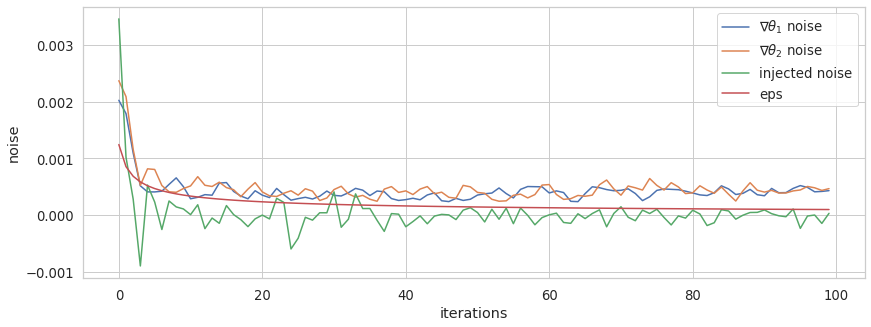

In [13]:
## create a subplots
fig, ax = plt.subplots(figsize=(14, 5))

## display injected noise
ax.plot(grad_1, label=r'$\nabla\theta_1$ noise')
ax.plot(grad_2, label=r'$\nabla\theta_2$ noise')
ax.plot(noises, label='injected noise')
ax.plot([epsilon(t) for t in range(1, n_iter+1)], label='eps')
ax.set_xlabel('iterations')
ax.set_ylabel('noise')
ax.legend()
plt.show()

>**Comment:** The figure above confirms the idea of two phases to the stochastic gradient Langevin algorithm. The first phase where the stochastic gradient noise dominates the injected noise, and a second phase where the converse occurs.

#### **3.2. Logistic Regression**
For this second example, we apply stochastic gradient Langevin algorithm to a Bayesian logistic regression model.
We will be using the data from the *UCI* dataset, more specificaly, the *a9a* dataset which consists of 32561 observations and 123 features.

$$
p(y_i|x_i) = \sigma(y_i\beta^Tx_i)
$$
Where $\beta$ are the parameters, and $\sigma$ is the sigmoid function.

We use a Laplace prior for $\beta$ and with a scale of 1. The gradient of the log likelihood is: $\frac{\partial}{\partial\beta}\log{p(y_i|x_i)} = \sigma(-y_i\beta^T x_i) y_ix_i$. And the prior is just the $-sign(\beta)$.

In [14]:
def sigmoid(z):
    """sigmoid function"""
    
    return 1 / (1 + np.exp(-z))

def log_likelihood(X, beta, y):
    """return the Log Likelihood for Logistic regression
    
    Parameters
    ----------
    X: array-like of shape (n_samples, d),
        The data points.
        
    y: array-like of shape (n_samples, ),
        The target values.
        
    beta: array-like of shape(d,),
        The parameters.
        
    Returns
    -------
    log_lik: float,
        The Log Likelihood.
    """
    
    ## compute scores B^T.X
    scores = X.dot(beta)

    ## compute log likelihood
    log_lik = np.sum(y * scores - np.log(1 + np.exp(scores)))
    
    return log_lik

def grad_log_likelihood(X, beta, y):
    grad_log_lik = []
    for j in range(beta.shape[0]):
        grad = (y - X.dot(beta)) * X[:, j]
        grad_log_lik.append(grad)
    grad_log_lik = np.asarray(grad_log_lik)

    return grad_log_lik[0, :]

def grad_prior(beta):
    """return the gradient of the prior"""
    
    ## grad prior = -sign(beta)
    grad_p = -np.sign(beta)
    
    return grad_p

**Load data**

In [15]:
## upload "a9a" dataset
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)

## number of samples to pick
n_samples = 1000
X = X[:n_samples]
y = y[:n_samples]
N, d = X.shape

print(f'> Number of samples : {N}')
print(f'> Number of features: {d}')

> Number of samples : 1000
> Number of features: 123


**Split data**

In [16]:
## split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print(f"> Number of training samples: {X_train.shape[0]}")
print(f"> Number of testing samples : {X_test.shape[0]}")

> Number of training samples: 800
> Number of testing samples : 200


**Train & Evaluate**

In [17]:
## parameters
n_iter = 100
batch_size = 1

## fit the model
thetas, noises = SGLD(X_train, grad_prior, grad_log_likelihood, batch_size, epsilon, n_iter, y_train, 0)

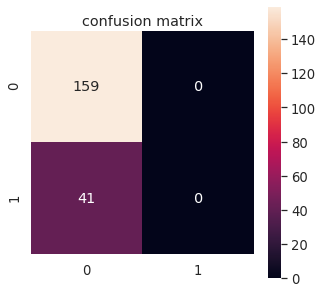

In [18]:
## make predictions

y_pred = np.sign(X_test.dot(thetas[-1]))

## confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=(-1, 1))

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, ax=ax, annot=True, square=True, fmt='.3g')
ax.set_title('confusion matrix')
plt.show()

#### **3.3. Independent Components Analysis**

In [ ]:
## NOT ENOUGH TIME TO COVER THIS PART :(

### **Thoughts & Takeaways**
- The paper is will written and well explained.
- We managed to understand the majority of the proofs and theoretical aspects.
- The proposed method is very interesting since it brings together two different aspects of machine learning, Bayesian learning and stochastic gradient.
- The experiments are done using a variety of basic and well known models (e.g. mixture of Gaussians, logistic regression, etc.).
- The part about Independent Components Analysis is much harder to understand.

### **References** 
@inproceedings{welling2011bayesian,
  title={Bayesian learning via stochastic gradient Langevin dynamics},
  author={Welling, Max and Teh, Yee W},
  booktitle={Proceedings of the 28th international conference on machine learning (ICML-11)},
  pages={681--688},
  year={2011},
  organization={Citeseer}
}

---
<p style="text-align: center;">Copyright © 2021 Omar Ikne & Zakaria Boulkhir</p>